#### 数据处理

In [1]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path):
    """查找符合通配符要求的文件"""
    return glob.glob(path)

print(findFiles("data/names/*.txt"))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [3]:
all_letters = string.ascii_letters + ".,;'-"
# ascii_letters方法:生成全部字母，包括a-z,A-Z
n_letters = len(all_letters) + 1    #字符种类数

#unicodedata.normalize():将Unicode文本标准化(NFC表示字符应该由整体组成)
#unicodedata.category():返回字符在unicode里分类的类型
def unicodeToAscii(s):
    """将 Unicode 转换为 ASCII """
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn' 
        and c in all_letters
        )   
    
print(unicodeToAscii("O'Néàl")) #验证unicodeToAscii函数

O'Neal


In [4]:
#定义 readLines 函数，读取文件并将文件每一行内容的编码转换为 ASCII
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]
print(readLines('data/names/Polish.txt'))

['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz', 'Bernard', 'Bobienski', 'Bosko', 'Broz', 'Brzezicki', 'Budny', 'Bukoski', 'Bukowski', 'Chlebek', 'Chmiel', 'Czajka', 'Czajkowski', 'Dubanowski', 'Dubicki', 'Dunajski', 'Dziedzic', 'Fabian', 'Filipek', 'Filipowski', 'Gajos', 'Gniewek', 'Gomolka', 'Gomulka', 'Gorecki', 'Gorka', 'Gorski', 'Grzeskiewicz', 'Gwozdek', 'Jagoda', 'Janda', 'Janowski', 'Jaskolski', 'Jaskulski', 'Jedynak', 'Jelen', 'Jez', 'Jordan', 'Kaczka', 'Kaluza', 'Kaminski', 'Kasprzak', 'Kava', 'Kedzierski', 'Kijek', 'Klimek', 'Kosmatka', 'Kowalczyk', 'Kowalski', 'Koziol', 'Kozlow', 'Kozlowski', 'Krakowski', 'Krol', 'Kumiega', 'Lawniczak', 'Lis', 'Majewski', 'Malinowski', 'Maly', 'Marek', 'Marszaek', 'Maslanka', 'Mencher', 'Miazga', 'Michel', 'Mikolajczak', 'Mozdzierz', 'Niemczyk', 'Niemec', 'Nosek', 'Nowak', 'Pakulski', 'Pasternack', 'Pasternak', 'Paszek', 'Piatek', 'Piontek', 'Pokorny', 'Poplawski', 'Rog', 'Rudaski', 'Rudawski', 'Rusnak', 'Rutkowski', 'Sadowski

In [5]:
#定义 category_lines 字典和 all_categories 列表
# category_lines: key 为语言的类别，value 为名称的列表
# all_categories:所有语言的种类。
category_lines = {}
all_categories = []
#os.path.splitext(“文件路径”):分离文件名与扩展名；默认返回(fname,fextension)元组
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] #将文件名设置为种类名
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)
print('# categories:', n_categories, all_categories)

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


#### 创建网络

In [6]:
class RNN(nn.Module) :
    def __init__(self,input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size,hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size,output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined )
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

#### 准备训练

In [7]:
#定义通过 randomTrainingPair 函数，随机选择一种语言和其中一个名称作为训练数据。
# 随机选择
def randomChoice(lst):
    return lst[random.randint(0, len(lst) - 1)]

# 随机选择一种语言和一个名称
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [8]:
#定义 categoryTensor 函数将类别转换成维度大小为 1*n_categories 的 one-hot张量。
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1,len(all_categories))
    tensor[0][li] = 1
    return tensor

#定义 inputTensor 函数,将输入转换成一个由首字母到尾字母(不包括 EOS)组成的 one-hot 矩阵。
def inputTensor(line):
    tensor = torch.zeros(len(line),1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] =1
    return tensor

#定义 targetTensor 函数，将目标值准换成一个由第二个字母到尾字母 (包括EOS) 组成的张量。
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

#使用 randomTrainingExample 函数来获取随机对(category, line),将其转换为所需格式的(category, input, target)张量。
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

#### 训练网络

In [21]:
#实例化 RNN 模型，并设置损失函数、学习率、迭代次数等参数，同时初始化损失值
rnn = RNN(n_letters,128,n_letters)
criterion = nn.NLLLoss()
learning_rate = 0.0005
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

In [22]:
#定义训练函数 train，与仅使用最后一个输出的分类相反，我们在每个步骤进行预测，因此在每个步骤都计算损失。
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    #unsqueeze少了一个下划线会报错Expected input batch_size (1) to match target batch_size (0).
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

        loss.backward(retain_graph=True)
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item() / input_line_tensor.size(0)

In [23]:
#执行训练,每经过 print——every=5000 次选代就打印一次,分别打印选代次数迭代进度和损失值等。
# 根据每经过 plot_every=500 次选代就计算平均损失,将其添加进 all_losses 列表便于后面绘制训练过程中损失函数的图像。
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    if iter % print_every == 0:
        print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, loss))
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

(5000 5%) 3.0812
(10000 10%) 2.3531
(15000 15%) 2.3953
(20000 20%) 2.6467
(25000 25%) 3.4537
(30000 30%) 2.8119
(35000 35%) 1.4942
(40000 40%) 1.8955
(45000 45%) 1.3443
(50000 50%) 2.4474
(55000 55%) 1.4420
(60000 60%) 2.7475
(65000 65%) 2.2580
(70000 70%) 2.7045
(75000 75%) 2.2840
(80000 80%) 3.2191
(85000 85%) 3.1372
(90000 90%) 3.0178
(95000 95%) 2.7602
(100000 100%) 1.7187


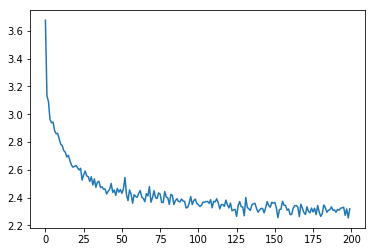

In [24]:
plt.figure()
plt.plot(all_losses)

#### 验证阶段

In [25]:
#在训练结束后，对获得的模型进行验证。这里，我们向网络中输入一个字母并推理得出下一个字母。将输出的字母作为下一步的输入，重复执行直到 EOS 标记处。
max_length = 20
def sample(category,start_letter='A'): # 根据类别、起始字母、隐藏状态开始推理
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        output_name = start_letter
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        return output_name

In [26]:
#遍历提供的宇母，得到输出名称
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print('语言类型:%s 首字母: %s 输出结果: %s' %(category,start_letter,
                                           sample(category,start_letter)))
        
samples('Russian','RUS')
samples('German','GER')
samples('Spanish','SPA')
samples('Chinese','CHI')

语言类型:Russian 首字母: R 输出结果: Romakev
语言类型:Russian 首字母: U 输出结果: Ullinikov
语言类型:Russian 首字母: S 输出结果: Sakhantovins
语言类型:German 首字母: G 输出结果: Grenter
语言类型:German 首字母: E 输出结果: Echer
语言类型:German 首字母: R 输出结果: Romeren
语言类型:Spanish 首字母: S 输出结果: Sovalar
语言类型:Spanish 首字母: P 输出结果: Pallan
语言类型:Spanish 首字母: A 输出结果: Alarana
语言类型:Chinese 首字母: C 输出结果: Can
语言类型:Chinese 首字母: H 输出结果: Hang
语言类型:Chinese 首字母: I 输出结果: Ina
